In [43]:
"""
new objective
- compare unprocessed data vs processed data
    - run 1 set of algos (SVC, RF, XGB, NN?) on unprocessed data
    - run the same set on processed data
- develop pre-processing code to be used for other projects?

- summarize results at the end, show:
    - the effect of each step on test set? 
    - the results of different models

- pre-processing steps: 
    - remove high-correlation vars
    - remove high VIF vars
    - handle missing vars
    - create missing indicators
    - perform PCA?
    - perform hyper-param optimization (using hyperopt)

- to do
    - might have to combine all the models into 1 function
    - relook at the metric of choice - is it correct?


this notebook will focus on optimizing the worst performing algorithm (Support Vectors) and only using 5K records for faster run-times

after hyperparam optimization:
- f1-score: 0.80 -> 0.89
- recall: 0.68 -> 0.74 (focusing on recall to reduce false negatives to catch more defaults;
but if biz objective is to increase # of clients who can get loans, we could focus on precision instead)
- precision: ?


"""

'\nnew objective\n- compare unprocessed data vs processed data\n    - run 1 set of algos (SVC, RF, XGB, NN?) on unprocessed data\n    - run the same set on processed data\n- develop pre-processing code to be used for other projects?\n\n- summarize results at the end, show:\n    - the effect of each step on test set? \n    - the results of different models\n\n- pre-processing steps: \n    - remove high-correlation vars\n    - remove high VIF vars\n    - handle missing vars\n    - create missing indicators\n    - perform PCA?\n    - perform hyper-param optimization (using hyperopt)\n\n- to do\n    - might have to combine all the models into 1 function\n    - relook at the metric of choice - is it correct?\n\n\nthis notebook will focus on optimizing the worst performing algorithm (Support Vectors) and only using 5K records for faster run-times\n\nafter hyperparam optimization:\n- f1-score: 0.80 -> 0.89\n- recall: 0.68 -> 0.74 (focusing on recall to reduce false negatives to catch more def

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

""" OPTIONS - to not truncate rows/columns """
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
pd.options.display.max_colwidth = 20

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet


In [45]:
X_vars = pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv', nrows=5000)
y_labels = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv', nrows=5000)

df = X_vars.merge(y_labels, how='left', on='customer_ID', validate='m:1')

assert ~df['target'].isna().any()

In [46]:
# 
df = df.drop(columns=['customer_ID', 'S_2'])

In [47]:
target_var = 'target'
df[target_var].value_counts()

0    3735
1    1265
Name: target, dtype: int64



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='target', ylabel='Density'>

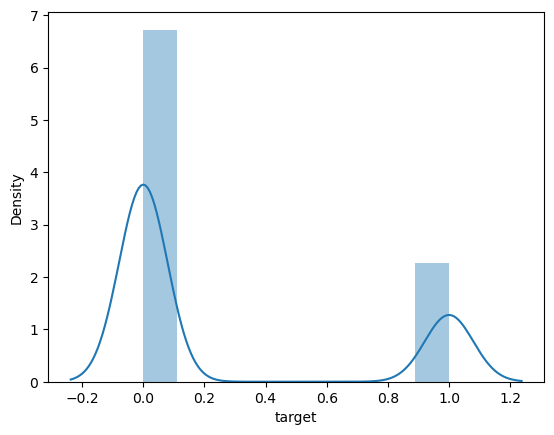

In [48]:
# check distribution of target var
import seaborn as sns

sns.distplot(df[target_var])

# EDA

In [49]:
def drop_highly_correlated_vars1(df, corr_thres=0.7):
    """
    checks for groups of variables with high correlation, 
    and for each group, keep the var with highest correl to target variable
    and delete the other variables
    
    but what if the selected var is then deleted because it also belongs to another set?
    
    """
    
    X = df.drop(target_var, axis=1)
    X_num = X[num_cols]
    y = df[target_var]
    
    vars_to_keep = []
    vars_to_drop = []
    
    """
    implementation of high-correlation vars - use corr matrix or pairwise calcs?
    - do they give the same end result? maybe
    - code both ways and see?
    
    corr matrix way might be hard to troubleshoot
    
    how to make sure we are dropping the correct vars?
    
    """
    
    # method 1 - pairwise corr
    all_high_corr_vars = []
    
    for col in X_num:
        corr_X_vars_w_col = X_num.drop(columns=col).corrwith(df[col], numeric_only=True).abs()
        high_corr_vars = corr_X_vars_w_col[corr_X_vars_w_col > corr_thres]

        all_high_corr_vars.extend(high_corr_vars.index.tolist()) 
    
    all_high_corr_vars = set(all_high_corr_vars) 
    print(len(all_high_corr_vars))
            
#     # for groups vars with high correl, delete and keep just the 1 var with highest corr with target var
    
#     vars_to_keep = list(set(vars_to_keep))
#     vars_to_drop = list(set(vars_to_drop))
    
    return None

# vars_to_keep = 
# drop_highly_correlated_vars1(df, corr_thres=0.7) 

In [50]:
def drop_highly_correlated_vars2(df, corr_thres=0.7):
    """
    checks for groups of variables with high correlation, 
    and for each group, keep the var with highest correl to target variable
    and delete the other variables
    
    but what if the selected var is then deleted because it also belongs to another set?
    
    """
    
    X = df.drop(target_var, axis=1)
    X_num = X[num_cols]
    y = df[target_var]
    
    vars_to_keep = []
    vars_to_drop = []
    
    """
    implementation of high-correlation vars - use corr matrix or pairwise calcs?
    - do they give the same end result? maybe
    - code both ways and see?
    
    corr matrix way might be hard to troubleshoot
    
    how to make sure we are dropping the correct vars?
    
    """     
        
    # method 2 - corr matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Get the upper triangle of the correlation matrix - a bit difficult to understand and hence troubleshoot
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than 0.7
    highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]

    
    for col in corr_matrix:
        df_col = corr_matrix[col]
        high_corr = df_col[(df_col>corr_thres) & (df_col<1)]
        high_corr_lst = high_corr.index.tolist() + [col]
        
        if len(high_corr) > 1:
#             print(col)
#             print(high_corr_lst)

#             for index, value in high_corr.items(): # corr of col with other cols
#                 print(index, ":", value)
            
            print()
            
            # get corr of highly correlated variables with target variable
            corr_with_target = df[high_corr_lst].corrwith(y).abs()
            print(corr_with_target)
            
            var_to_keep = corr_with_target.idxmax()
            
            vars_to_keep.extend([var_to_keep])
            print(var_to_keep)
            vars_to_drop.extend([corr_with_target.index.difference(var_to_keep)])
            
            print()

#     # for groups vars with high correl, delete and keep just the 1 var with highest corr with target var
    
#     vars_to_keep = list(set(vars_to_keep))
#     vars_to_drop = list(set(vars_to_drop))
    
    return None

# vars_to_keep = 
# drop_highly_correlated_vars2(df, corr_thres=0.7) 

In [51]:
def drop_highly_correlated_vars3(df, corr_thres=0.7):
    """
    just delete highly corr vars without consideration of corr to target var
    
    implementation of high-correlation vars - use corr matrix or pairwise calcs?
    - do they give the same end result? different
    - code both ways and see?
    
    corr matrix way might be hard to troubleshoot
    
    how to make sure we are dropping the correct vars?
    
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.difference([target_var])
    print(f'cat cols: {cat_cols}')

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference([target_var])
    print(f'num cols: {num_cols}')
    
    
    X = df.drop(target_var, axis=1)
    X_num = X[num_cols]
    y = df[target_var]
    
    vars_to_keep = []
    vars_to_drop = []
        
    # method 2 - corr matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Get the upper triangle of the correlation matrix - a bit difficult to understand and hence troubleshoot
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than 0.7
    highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]

    vars_to_drop = highly_correlated_features.copy()
    vars_to_keep = list(set(X_num) - set(vars_to_drop))
    
    # drop vars
    df_drop = df[vars_to_keep]
    
    print(f'{len(vars_to_drop)} columns with high correlation were dropped')
        
    # append target variable back
    df_drop = pd.concat([df_drop, y], axis=1)
    
    return df_drop

unprocessed_df = df.copy()
processed_df = drop_highly_correlated_vars3(df, corr_thres=0.7) 

cat cols: Index(['D_63', 'D_64'], dtype='object')
num cols: Index(['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17',
       'B_18',
       ...
       'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8',
       'S_9'],
      dtype='object', length=186)
77 columns with high correlation were dropped


In [52]:
# # shift target variable to front
# df_train = df_train[['target'] + [col for col in df_train.columns if col != 'target']]

# correlation between variables 
# corr_with_target = df_train.corr()['target'].drop('target')
# corr_with_target

# feature engineering

In [53]:
"""

- create missing indicators?


"""




'\n\n- create missing indicators?\n\n\n'

# modeling prep

In [64]:
def handle_missing_values(df, display_missing_vals, fill_mean_thres=0.1, drop_thres=0.9):
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.difference([target_var])
#     print(f'cat cols: {cat_cols}')

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference([target_var])
#     print(f'num cols: {num_cols}')
    
    
    def handle_missing_num_cols(df):
        if display_missing_vals:
            # display missing values %
            print('% missing values')
            perc_na = df.isna().mean() * 100
            print(perc_na[perc_na > 0].sort_values(ascending=False))

        # drop cols with high % of missing values
        missing_perc = df.drop(columns=target_var).isna().mean()

        drop_cols = list(missing_perc[missing_perc > drop_thres].index)

        print(f"Dropping columns with more than {drop_thres*100}% missing values: {drop_cols}\n")
        df = df.drop(columns=drop_cols)

        # Fill missing values with column means for columns with less than 10% missing values
        fill_mean_cols = list(missing_perc[(missing_perc <= fill_mean_thres) & (missing_perc > 0)].index)

        print(f"Filling columns with less than {fill_mean_thres*100}% missing values with their means: {fill_mean_cols}\n")
        df[fill_mean_cols] = df[fill_mean_cols].fillna(df.mean())
        
        return df
    
    def handle_missing_cat_cols(df):
        df[cat_cols] = df[cat_cols].fillna('None')
        
        return df
    
    
    df = handle_missing_num_cols(df) 
    df = handle_missing_cat_cols(df)
        
    return df
        
# model_df = handle_missing_values(model_df, fill_mean_thres=0.8, drop_thres=0.8, display_missing_vals=False)

In [65]:
def scale_num_vars(df):
    # scale numeric vals
    from sklearn.preprocessing import StandardScaler

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference([target_var])
    
    scaler = StandardScaler()
    num_df = df[num_cols]

    scaler.fit(df[num_cols])
    df_scaled = pd.DataFrame(scaler.transform(df[num_cols]), columns=num_cols)
        
    # concat back to original df
    df_comb = pd.concat([df.drop(columns=num_cols), df_scaled], axis=1)
    
    assert df.shape == df_comb.shape
    
    return df_comb

def encode_cat_vars(df):
    # encode cat vars
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder

    df_shape = df.shape
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.difference([target_var])
    
    # using label encoder
    label_encoders = {}
    
    for col in cat_cols:
        label_encoders[col] = LabelEncoder() # one labelencoder for each col?
        df[col] = label_encoders[col].fit_transform(df[col].values)
    
    
    # using one-hot encoder - 
    
    assert df.shape == df_shape
    
    return df

# # model_df = scale_num_vars(model_df) # cols are alr scaled
# model_df = encode_cat_vars(model_df)

In [66]:
# X = model_df.drop(columns=[target_var])
# y = model_df[target_var]

# PCA

In [67]:
# # use PCA to reduce collinearity
# pca = PCA(n_components=5)
# pca.fit(X)

# # get the explained variance ratio
# variance_ratio = pca.explained_variance_ratio_

# # plot the scree plot
# """ for scree plot, choose the # of vars when it starts to taper off """
# plt.plot(np.arange(1, len(variance_ratio)+1), variance_ratio, 'bo-', linewidth=2)
# plt.xlabel('Principal Component')
# plt.ylabel('Proportion of Variance Explained')
# plt.title('Scree Plot')
# plt.show()

In [68]:
# pca = PCA(n_components=2) # number of components to keep
# X = pca.fit_transform(X)

In [69]:
# # split the dataset into training and testing sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# model fitting

# support vectors

In [70]:
# print('baseline model performance')
# print('Support Vector Classifier: Accuracy Score =', accuracy_score(y_val, y_pred),
#     ', F1 Score =', f1_score(y_val, y_pred),
#     ', Recall =', recall_score(y_val, y_pred))#, average='weighted')) # using weighted average seems to give importance to the minority class, which is the class of interest


# # focus
# # 5K - Support Vector Classifier: Accuracy Score = 0.904 , F1 Score = 0.8095238095238094
# # 5K (after removing date?) - Support Vector Classifier: Accuracy Score = 0.9 , F1 Score = 0.8023715415019763
# # 5K (after hyperparam optimize): Test f1-score:  0.8870967741935483


# # 10K - Support Vector Classifier: Accuracy Score = 0.8945 , F1 Score = 0.7965284474445516
# # 20K - Support Vector Classifier: Accuracy Score = 0.893 , F1 Score = 0.7967711301044634

In [71]:
def display_confusion_matrix(y_val, y_pred, model):
    # evaluate the model using confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=model.classes_)

    disp.plot()
    plt.show()

    print(cm)

    return None

def run_svc(X_train, X_val, y_train, y_val):
    # create base svc model with standard params
    # not sure if this part is actually correct
    svc = SVC(kernel='linear', C=1, random_state=42)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    recall_scores = cross_val_score(svc, X_train, y_train, cv=cv, scoring='recall')
    recall = round(recall_scores.mean(), 2)

#     print("Cross-validation recall-score for base SVC model with K-fold cross-validation: ", recall)

    # fitting the SVC model with just the basic params
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)

    # f1 = f1_score(y_val, y_pred)#, average='weighted')
    # print("Test f1-score: ", f1)

    """ eval metrics """
    recall = recall_score(y_val, y_pred)
#     print("Test recall score for base SVC model with K-fold cross-validation: ", recall)

#     display_confusion_matrix(y_val, y_pred, model=svc)
    
    return recall

def run_rf(X_train, X_val, y_train, y_val):
    
    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42) # class_weight='balanced_subsample'
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

#     print('Random Forest Classifier: Accuracy Score =', accuracy_score(y_val, y_pred),
#           ', F1 Score =', f1_score(y_val, y_pred))

    # 1K - Random Forest Classifier: Accuracy Score = 0.975 , F1 Score = 0.9425287356321839
    # 5K - Random Forest Classifier: Accuracy Score = 0.941 , F1 Score = 0.8822355289421159
    # 10K - Random Forest Classifier: Accuracy Score = 0.945 , F1 Score = 0.8917322834645669
    # 20K - Random Forest Classifier: Accuracy Score = 0.95025 , F1 Score = 0.9030686799805162

    """ eval metrics """
    recall = recall_score(y_val, y_pred)
#     print("Test recall score for base rf model with K-fold cross-validation: ", recall)
    
    
#     display_confusion_matrix(y_val, y_pred, model=rf)

    
    return recall


In [72]:
def run_models(df):
    
    model_df = df.copy()    
    model_df = handle_missing_values(model_df, fill_mean_thres=0.8, drop_thres=0.8, display_missing_vals=False)    
    
    # model_df = scale_num_vars(model_df) # cols are alr scaled
    model_df = encode_cat_vars(model_df)
    
    X = model_df.drop(columns=[target_var])
    y = model_df[target_var]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    """ baseline """
    svc_recall = run_svc(X_train, X_val, y_train, y_val)
    rf_recall = run_rf(X_train, X_val, y_train, y_val)   
#     xgb_recall = run_xgb(X_train, X_val, y_train, y_val)   

    """ hyper-param optimized """

    
    

    
    return svc_recall, rf_recall



""" rows - increasing processing steps, cols - different models, sep tables for indiv metrics """

# add recall to a summary table
results = pd.DataFrame()


print('running models on unprocessed data...')
unpro_svc_recall, unpro_rf_recall = run_models(unprocessed_df)

print('running models on processed data...')
pro_svc_recall, pro_rf_recall = run_models(processed_df)


""" append results """

results = results.append({'Model': 'SVC - unprocessed', 'Recall': unpro_svc_recall}, ignore_index=True)
results = results.append({'Model': 'SVC - processed', 'Recall': pro_svc_recall}, ignore_index=True)


results = results.append({'Model': 'RF - unprocessed', 'Recall': unpro_rf_recall}, ignore_index=True)
results = results.append({'Model': 'RF - processed', 'Recall': pro_rf_recall}, ignore_index=True)

results = results.round(2)

results

running models on unprocessed data...
Dropping columns with more than 80.0% missing values: ['D_42', 'D_49', 'D_66', 'D_73', 'D_76', 'R_9', 'B_29', 'D_87', 'D_88', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']

Filling columns with less than 80.0% missing values with their means: ['P_2', 'S_3', 'D_43', 'D_44', 'D_46', 'D_48', 'B_8', 'D_50', 'D_52', 'P_3', 'D_53', 'S_7', 'D_55', 'D_56', 'B_13', 'S_9', 'D_59', 'D_61', 'B_15', 'D_62', 'D_64', 'B_17', 'D_68', 'D_69', 'D_70', 'D_72', 'D_74', 'D_77', 'B_25', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'R_20', 'D_89', 'D_91', 'S_22', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'R_27', 'D_109', 'D_112', 'S_27', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'B_41', 'D_130', 'D_131', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


running models on processed data...
Dropping columns with more than 80.0% missing values: ['D_66', 'R_26', 'D_111', 'D_42', 'D_49', 'D_87', 'B_29', 'D_106', 'R_9']

Filling columns with less than 80.0% missing values with their means: ['D_130', 'D_69', 'D_115', 'D_79', 'D_62', 'S_3', 'D_44', 'S_9', 'D_72', 'D_59', 'D_83', 'D_43', 'B_17', 'B_25', 'D_53', 'D_70', 'D_52', 'D_91', 'S_26', 'D_109', 'P_3', 'S_25', 'D_112', 'B_41', 'D_125', 'D_89', 'D_123', 'D_46', 'D_140', 'D_68', 'D_81', 'D_56', 'S_22', 'D_102', 'D_50', 'D_145', 'D_116', 'D_78', 'P_2', 'D_80', 'R_20', 'D_139', 'D_144', 'R_27']



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Model,Recall
0,SVC - unprocessed,0.79
1,SVC - processed,0.75
2,RF - unprocessed,0.88
3,RF - processed,0.83


# hyperpara optimization - hyperopt

In [ ]:
# svc hyperpara optimization - hyperopt
"""
gridsearchCV is quite a brute-force way to optimize hyperparams as it explores all combinations of hyperparams

hyperopt is generally better than gridsearchCV as it is more flexible and optimized for the search space, and can scale well with larger datasets
and more complex models since it stops evaluating unpromising hyperparameter combinations much faster than GridSearchCV
"""

# define objective function with K-fold cross-validation to maximize recall score
def objective(space):
    svc = SVC(C=space['C'], kernel=space['kernel'], gamma=space['gamma'])
    cv = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(svc, X_train, y_train, cv=cv, scoring='recall')
    
    return {'loss': -scores.mean(), 'status': STATUS_OK}
#     f1 = f1_score(y_val, y_pred)#, average='weighted')
#     return {'loss': -f1, 'status': STATUS_OK}



# define the search space for hyperparameters
search_space = {
    'C': hp.uniform('C', 0.1, 10),
    'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid']),
    'gamma': hp.choice('gamma', ['auto', 'scale']),
}

# call the fmin function to optimize the objective function
best = fmin(objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials(), verbose=1)

# print the best hyperparameters and test recall score
print("Best hyperparameters: ", best)

In [ ]:
best_params = space_eval(search_space, best)

# fit the final model using best hyperparameters
best_svc = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])
best_svc.fit(X_train, y_train)
y_pred = best_svc.predict(X_val)

# evaluate the model using K-fold cross-validation and compute f1 and recall score
# f1_score = f1_score(y_val, y_pred)
# print("Test f1-score using K-fold cross-validation and hyperopt: ", f1_score)

recall = recall_score(y_val, y_pred)
print("Test recall score using K-fold cross-validation and hyperopt: ", recall)

In [ ]:
# svc hyperpara optimization - hyperopt
"""
gridsearchCV is quite a brute-force way to optimize hyperparams as it explores all combinations of hyperparams

hyperopt is generally better than gridsearchCV as it is more flexible and optimized for the search space, and can scale well with larger datasets
and more complex models since it stops evaluating unpromising hyperparameter combinations much faster than GridSearchCV
"""

# define objective function for hyperopt to optimize
def objective(space):
    """
    This is the objective function that will be optimized using F1-score
    """
    svc = SVC(C=space['C'], kernel=space['kernel'], gamma=space['gamma'])
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)
#     f1 = f1_score(y_val, y_pred)#, average='weighted')
#     return {'loss': -f1, 'status': STATUS_OK}

    recall = recall_score(y_val, y_pred)
    return {'loss': -recall, 'status': STATUS_OK}


# define the search space for hyperopt
search_space = {
    'C': hp.uniform('C', 0.1, 10),
    'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid']),
    'gamma': hp.choice('gamma', ['auto', 'scale']),
}

# call the fmin function to optimize the objective function
best = fmin(objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials(), verbose=1)

# print the best hyperparameters and test f1-score
print("Best hyperparameters: ", best)

In [ ]:
best_params = space_eval(search_space, best)

# fit the final model using best hyperparameters and compute the f1-score on the test set
best_svc = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])
best_svc.fit(X_train, y_train)
y_pred = best_svc.predict(X_val)

f1 = f1_score(y_val, y_pred)#, average='weighted')
print("Test f1-score: ", f1)

recall = recall_score(y_val, y_pred)
print("Test recall: ", recall)

# random forest

# XGBoost

In [ ]:
# XGBoost Classifier
xgb = XGBClassifier(random_state=42) # scale_pos_weight=sum(target==0)/sum(target==1), 
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
print('XGBoost Classifier: Accuracy Score =', accuracy_score(y_val, y_pred),
      ', F1 Score =', f1_score(y_val, y_pred))

# 5K - XGBoost Classifier: Accuracy Score = 0.982 , F1 Score = 0.96484375
# 10K - XGBoost Classifier: Accuracy Score = 0.9755 , F1 Score = 0.9524733268671194
# 20K - XGBoost Classifier: Accuracy Score = 0.9755 , F1 Score = 0.953199617956065

In [ ]:
# evaluate the model using confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb.classes_)
disp.plot()
plt.show()

print(cm)

In [ ]:
cr = classification_report(y_val, y_pred)
print(cr)

# xgboost - hyperparams tuning

In [ ]:
# import xgboost as xgb
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from hyperopt import fmin, hp, tpe, Trials
# from sklearn.metrics import accuracy_score

# # load iris dataset
# iris = load_iris()
# X = iris.data
# y = iris.target

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # define the search space for Hyperopt
# space = {
#     'max_depth': hp.choice('max_depth', range(1, 10)),
#     'learning_rate': hp.loguniform('learning_rate', -5, 0),
#     'n_estimators': hp.choice('n_estimators', range(50, 500)),
#     'gamma': hp.loguniform('gamma', -5, 0),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
#     'subsample': hp.uniform('subsample', 0.1, 1),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, 5),
#     'reg_lambda': hp.loguniform('reg_lambda', -5, 5),
#     'objective': 'multi:softmax',
#     'num_class': 3
# }

# # define the objective function for Hyperopt
# def objective(params):
#     model = xgb.XGBClassifier(**params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     return {'loss': 1-accuracy, 'status': 'ok'}

# # set the number of trials for Hyperopt
# trials = Trials()

# # run the Hyperopt search
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
# print("Best Hyperparameters:", best)

# check if over or underfitting

In [ ]:
# make predictions on the train and test sets
y_pred_train = xgb.predict(X_train)

# evaluate the performance of the model
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred)
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Val Accuracy: %.2f%%" % (val_accuracy * 100.0))
print()

train_f1_score = f1_score(y_train, y_pred_train)
val_f1_score = f1_score(y_val, y_pred)
print("Train f1 score: %.2f%%" % (train_f1_score * 100.0))
print("Val f1 score: %.2f%%" % (val_f1_score * 100.0))

In [ ]:
# from sklearn.metrics import mean_squared_error, r2_score

# # Train the XGBoost regressor model and plot the learning curve
# train_error = []
# test_error = []
# n_rounds = 100

# for i in range(n_rounds):
#     xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
#     y_train_pred = xgb.predict(X_train)
#     y_val_pred = xgb.predict(X_val)
#     train_error.append(mean_squared_error(y_train, y_train_pred))
#     test_error.append(mean_squared_error(y_val, y_val_pred))
    
# plt.plot(range(1, n_rounds+1), train_error, label='Training error')
# plt.plot(range(1, n_rounds+1), test_error, label='Validation error')
# plt.xlabel('Number of iterations')
# plt.ylabel('MSE')
# plt.legend(loc='best')
# plt.show()

# xgboost feature importance

In [ ]:
# get importance
importance = xgb.feature_importances_

feat_impt_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'feature_importance': importance}).sort_values(by='feature_importance', ascending=False)

feat_impt_df.head(10)

# xgboost shap values

In [ ]:
# create a SHAP explainer object
explainer = shap.Explainer(xgb)

# calculate SHAP values for all features
shap_values = explainer(X_train)

In [ ]:
shap.summary_plot(shap_values)#, max_display=999)

In [ ]:
# for i in range(-1, -21, -1):
#     var = shap_values[:, shap_values.abs.mean(0).argsort[i]]
#     # var = shap_values[:, 'Jerneh_Occupation_grp']
    
#     shap.plots.scatter(var, color=shap_values,
#         # xmin=var.percentile(1), xmax=var.percentile(99),
#         ymin=var.percentile(1), ymax=var.percentile(99),
#         # ymin=-0.1, ymax=0.1,
#         alpha=0.2,
#         # dot_size=2,
#         # x_jitter=0.1,
        
#     )

# model results

In [ ]:
# import mlflow

In [ ]:
# def amex_metric(y_true, y_pred):
#     labels = np.transpose(np.array([y_true, y_pred]))
#     labels = labels[labels[:, 1].argsort()[::-1]]
#     weights = np.where(labels[:,0]==0, 20, 1)
#     cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
#     top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
#     gini = [0,0]

#     for i in [1,0]:
#         labels = np.transpose(np.array([y_true, y_pred]))
#         labels = labels[labels[:, i].argsort()[::-1]]
#         weight = np.where(labels[:,0]==0, 20, 1)
#         weight_random = np.cumsum(weight / np.sum(weight))
#         total_pos = np.sum(labels[:, 0] *  weight)
#         cum_pos_found = np.cumsum(labels[:, 0] * weight)
#         lorentz = cum_pos_found / total_pos
#         gini[i] = np.sum((lorentz - weight_random) * weight)
    
#     return 0.5 * (gini[1]/gini[0] + top_four)

# amex_metric(y_val, y_pred_xgb)

In [ ]:
# from hyperas.distributions import choice, uniform

# # TODO: how do i run hyperopt on multiple models, if i don't want to let the model architecture be part of the 
# # 'tuning' per se?

# keep_loss = []

# space = {
#     'activation': choice('activation', ['relu','sigmoid']),
#     'dropout': uniform('dropout', 0, 1),
#     'batch_size': choice('batch_size', [64, 128]),
#     'learning_rate': uniform('learning_rate', 0.01, 1),
#     'clip_norm': uniform('clip_norm', 0.01, 1),
#     'num_nodes_input': choice('num_nodes_input', [100, 300, 500]),
#     'num_nodes_hidden': choice('num_nodes_hidden', [50, 150, 250]),
#     'num_nodes_output': choice('num_nodes_output', [25, 75, 150]),
#     'num_hidden_layers': uniform('num_hidden_layers', 1, 7),
#     # TODO: should we tune the # of epochs as well?
#     # 'num_epochs': uniform('num_epochs', 10, 100),
# }

# def objective_func(space_sample):

#     ## parse the hyper-parameter sample
#     activ = space_sample['activation']
#     dropout = space_sample['dropout']
#     size = space_sample['batch_size']
#     rate = space_sample['learning_rate']
#     clip_norm = space_sample['clip_norm']
#     input = space_sample['num_nodes_input']
#     hidden = space_sample['num_nodes_hidden']
#     output = space_sample['num_nodes_output']
#     hl = round(space_sample['num_hidden_layers'])
#     epochs = 50

#     model = Sequential()

#     model.add(Dense(input, input_shape=(X_train.shape[1],), activation=activ)) # the input_shape has to be same dim as the vectors
#     model.add(Dropout(dropout))

#     for i in range(hl):
#         model.add(Dense(hidden, activation=activ))
#         model.add(Dropout(dropout))

#     # TODO: maybe can add a batch normalization layer before the output layer?

#     model.add(Dense(output, activation=None)) 
#     model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # L2 normalize embeddings

#     from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
    
#     early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=7)
#     terminate = TerminateOnNaN()

#     model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', 
#         save_best_only=True, verbose=0)

#     model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=rate, clipnorm=clip_norm),
#             loss=tfa.losses.TripletSemiHardLoss(),
#         )
        
#     history = model.fit(
#             X_train, 
#             y_train, 
#             validation_data=(X_test, y_test), 
#             batch_size=size, 
#             epochs=epochs,
#             callbacks=[early_stop, terminate, model_checkpoint],
#             verbose=0
#         )        

#     plot_train_valid_loss(history)

#     '''
#     - for Siamese Network, running the model (i.e. .predict()) on X_val will not give us a 'prediction'/y-label,
#     unlike in a conventional ML/NN model
    
#     - what it provides instead is the 'embedding' of X_val in the 'embedding space' created by the model (think
#     of it as the 'location' of X_val in a 'transformed space')
    
#     - therefore we can't directly assign a label to the records in X_val; what we'll do instead is to:
#         - transform X_train into the same embedding space 
#         - compare each record of X_val to each record of X_train
#         - find the closest (min. euclidean dist) btw the 2 and use that as the loss (TBC)
#         - to calculate accuracy:
#         - (assign the label of that closest X_train record as the label for the X_val record)
#     '''

#     # or should i get the min or avg val_loss from history and use that as the loss?
#     # TODO: X_test or X_val?
    
#     def calc_min_euc_dist():
#         from scipy.spatial import distance

#         X_train_embed = history.model.predict(X_train)
#         X_val_embed = history.model.predict(X_val)
#         assert len(X_train_embed)==len(X_train)
#         assert len(X_val_embed)==len(X_val)

#         min_dist_all = [] # TODO: consider renaming this var

#         for embed_x_val in X_val_embed:
#             min_dist = []

#             for embed_x_train in X_train_embed:
#                 # calc all pairwise distances
#                 euc_dist = distance.euclidean(embed_x_train, embed_x_val)
#                 min_dist.append(euc_dist)
            
#             assert len(min_dist)==len(X_train)

#             min_dist = min(min_dist)

#             min_dist_all.append(min_dist)

#             # TODO: consider adding in y-label prediction for accuracy scoring?

#         assert len(min_dist_all) == len(X_val_embed)

#         # TODO: check if taking the sum of min_dist as the loss is correct
#         min_euc_dist = np.sum(min_dist_all)
#         print(min_euc_dist)
#         assert min_euc_dist!=0, keep_loss.append([X_train_embed, X_val_embed])

#         return min_euc_dist
    
#     loss = calc_min_euc_dist()

#     # loss = np.min(history.history['val_loss']) # prev method

#     return loss

In [ ]:
def test_function(keep_loss):

    X_train_embed = keep_loss[0][0]
    print(len(X_train_embed))

    X_val_embed = keep_loss[0][1]
    print(len(X_val_embed))

    return None

# test_function(keep_loss)

In [ ]:
# # load a saved model
# from keras.models import load_model
# saved_model = load_model('best_model.h5')

In [ ]:
def assign_y_label(history, X_train, y_train, X_val, n=1): 
    '''
    - for Siamese Network, running the model (i.e. .predict()) on X_val will not give us a 'prediction'/y-label,
    unlike in a conventional ML/NN model
    
    - what it provides instead is the 'embedding' of X_val in the 'embedding space' created by the model (think
    of it as the 'location' of X_val in a 'transformed space')
    
    - therefore we can't directly assign a label to the records in X_val; what we'll do instead is to:
        - transform X_train into the same embedding space 
        - compare each record of X_val to each record of X_train
        - find the closest (min. euclidean dist) btw the 2
        - assign the label of that closest X_train record as the label for the X_val record

    - smth about looking at N=3 closest...


    '''
    from scipy.spatial import distance

    X_val_embed = history.model.predict(X_val)
    X_train_embed = history.model.predict(X_train)

    y_pred = [] 

    for embed_x_val in X_val_embed:
        row_dist = []
        
        for embed_x_train in X_train_embed:
            # calc all pairwise distances
            euc_dist = distance.euclidean(embed_x_train, embed_x_val)
            row_dist.append(euc_dist)

        row_dist = np.array(row_dist)
        n_min_dist_idx = np.argpartition(row_dist, n)[:n] # returns indexs of N min dist
        y_pred.append(y_train[n_min_dist_idx]) # 
    
    y_pred = np.array(y_pred)

    assert len(y_pred) == len(X_val_embed)
    assert y_pred.shape[1] == n

    return y_pred

# y_pred = assign_y_label(history, X_train, y_train, X_val, n=5)
# note: for a single row in y_pred, there might be multiple of the same class

In [ ]:
# # visualize with tensorboard
# # load into https://projector.tensorflow.org/

# # Save test embeddings for visualization in projector
# np.savetxt("vecs.tsv", y_pred, delimiter='\t')

# out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# # for img, labels in tfds.as_numpy(test_dataset):
# #     [out_m.write(str(x) + "\n") for x in labels]

# for x in y_test_inversed:
#   out_m.write(str(x) + "\n")

# out_m.close()